<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 2 - Fronteras no Lineales </H3>
<hr style="height:2px;border:none"/>

<H3 align='center'> Jorge Contreras Cabrera 201573547-6  </H3>
<H3 align='center'> César Quiroz Mansilla 201573578-6   </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* similaridad: KNN
* SVM, Decision trees y Redes neuronales
* Tipos de fronteras de clasificación y regresión.
* Métodos de *kernel*.
* Selección de hı́per-parámetros estructurales en SVM, Arboles de Decisión, k-NN y Redes Neuronales.

### Paquetes de instalación

Como es usual utilizaremos *numpy, scipy, matplotlib* y *sklearn*. Además de éstas se necesitará instalar **keras**, una librerı́a en python para prototipado rápido de modelos basados en redes neuronales, muy similar en espı́ritu a *sklearn*. La librerı́a puede usar *TensorFlow* o *Theano* como backend, siendo éstas las librerı́as más populares para desarrollar nuevos modelos de redes neuronales o implementar eficientemente modelos conocidos con fines prácticos. Para detalles sobre la instalación puede revisar [[1]](#refs) o escribir un email a su ayudante.



La tarea se divide en secciones:

[1.](#primero) Tipos de fronteras en clasificación  
[2.](#segundo) Un problema* Multi-label*  
[3.](#tercero) *Taxi Trip Duration*: Predicción de duración de viaje  
[4.](#cuarto) Entendimiento de imágenes de personas

<a id="primero"></a>
## 1. Tipos de fronteras en clasificación

Como se ha discutido en clases, los problemas de clasificación pueden ser representados de distintas maneras, en donde estas representaciones definen un espacio de entrada del dominio de los datos ($\mathbb{R}_{\mathbb{X}}$). Los ejemplos dentro del espacio de entrada (*manifold*) pueden tener distintas formas, donde estas indicarán si es que estos ejemplos tendrán fronteras lineales o no. Con el propósito de analizar los distintos tipos de fronteras que definen los algoritmos de clasificación, se trabajará con un dataset sintético lo cual es ideal para analizar los diferentes tipos, así hacer un recorrido rápido por las grandes ideas en la búsqueda dela no-linealidad.

<a id="segundo"></a>
## 2. Un problema* Multi-label*

<img src="https://files.virgool.io/upload/users/12226/posts/oxo6jvmweqmr/1ios2rcvohwc.png" width="35%" style="float: right;" />

Un tipo de problema un poco diferente a la clásica clasificación que hemos visto es el de etiquetación múltiple o *multi-label* [[5]](#refs), en donde se debe asignar una *o un grupo* de etiquetas a un dato, es decir, puede ser tratado como un problema de clasificación donde las clases pasan a ser **NO** mutuamente excluyente, es decir puede ser asignada más de una a un dato. Este problema se ve muchas veces en imágenes que contienen más de algun objeto, por lo que las clases pasan a ser no excluyente, o en sí se transforma en un problema de *multi-label*. También aparece en texto cuando se debe asignar un tópico a un documento, ya que podría hablar de diferentes cosas, como religión, política, finanzas o educación, por lo que podría contener varios.


En esta actividad se trabajará con una versión liviana del dataset __[**NUS-WIDE**](https://lms.comp.nus.edu.sg/research/NUS-WIDE.htm)__ , el cual consta de imágenes extraídas de la web (Flickr.com) en donde los diferentes *tags* o conceptos asociados a la imagen pasan a ser las etiquetas/*labels*. De la página donde se alberga NUS-WIDE será necesario descargar:
* Concept List: http://dl.nextcenter.org/public/nuswide/ConceptsList.zip
* NUS-WIDE-Lite: http://dl.nextcenter.org/public/nuswide/NUS-WIDE-Lite.rar
* NUS-WIDE-Urls: http://dl.nextcenter.org/public/nuswide/NUS-WIDE-urls.rar

> a) Cargue los datos del *output* del modelo (*labels*), descríbalos ¿Cuántos ejemplos hay por cada clase?

In [5]:
import pandas as pd
import numpy as np
y = pd.read_csv("Pregunta2/NUS-WIDE-Lite/NUS-WIDE-Lite_groundtruth/Lite_GT_Train.txt",delimiter="\s",header=None,engine='python').values
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

> b) Visualice el tema de que un dato  (imagen en este caso) puede tener múltiples etiquetas. Comente sobre la definición del problema *multi-label* y cómo aplica en este caso.

Etiquetas de la imagen : ['clouds' 'lake' 'plants' 'sky' 'sun' 'sunset' 'water']


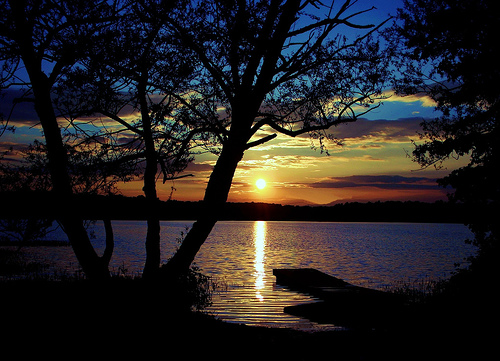

In [10]:
import re
from urllib.request import urlopen
label_names = np.loadtxt("Pregunta2/Concepts81.txt",dtype='object')
arch = open("Pregunta2/NUS-WIDE-urls.txt",'r') #lectura para mapeo de link a url
regex = re.compile("\s+")
image2url = {}
for line in arch.readlines():
    aux = regex.split(line.strip())
    image = aux[0].split("Flickr\\")[-1]
    url_m = aux[3]
    image2url[image] = url_m
arch.close()
arch = open("Pregunta2/NUS-WIDE-Lite/image list/Train_imageOutPutFileList.txt",'r')
data_urls = [image2url[line.strip()] for line in arch.readlines()]
arch.close()
"""Visualizacion"""
from PIL import Image
s = np.random.randint(0,len(data_urls)) #mostrar para una imagen random
category_sample = np.where(y[s]==1)[0] 
print("Etiquetas de la imagen :",label_names[category_sample])
im = Image.open(urlopen(data_urls[s]))
im

<a id="tercero"></a>

## 3. *Taxi Trip Duration*: Predicción de duración de viaje

<img src="https://upload.wikimedia.org/wikipedia/commons/4/4d/Newyorkcity_taxi_motion_banner.jpg" />


En esta actividad trabajaremos con un dataset de una competencia en la plataforma Kaggle, el cual se llama **New York City Taxi Trip Duration** y que puede ser accedido a través del siguiente __[link](https://www.kaggle.com/c/nyc-taxi-trip-duration/)__. Como se puede ver es una competencia para predecir la duración del viaje de un taxi en Nueva York, por lo que es un problema de regresión que resulta altamente no lineal  y no determinista debido a las invariantes que tiene, por ejemplo un viaje de un punto a otro puede durar distinto tiempo dependiendo de múltiples factores, como el horario, la congestión de ese día u otros.

La métrica de evaluación de la competencia y la que utlizaremos será el RMSLE (*Root Mean Squared Logarithm Error*):

$$
E(y,\hat{y}) = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left( \log{(y_i +1)}- \log{(\hat{y}_i+1}) \right)^2}
$$

O en código Python:
```python
import numpy as np
def rmsle(predicted,real):    
    suma=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        suma += np.power((p - r),2)
    return np.sqrt(suma/len(predicted))
```


Descarge los datos de la competencia, únicamente trabajaremos con el archivo *train.zip* o *train.csv*, ya que no conocemos los valores reales del conjunto *test*, tendrémos que simularlo.


> a) Cargue los datos de entrenamiento como *dataframes* de pandas. Describa las variables involucradas en el problema, explorando el tipo de datos de que se trata, el número de valores distinto. Grafique adecuadamente el valor a predecir con algún gráfico que resuma su comportamiento, e.g. un histograma, boxplot u otro.

In [1]:
import pandas as pd
df = pd.read_csv("Pregunta3/train.csv")
output = df['trip_duration'].values
print(df.info())
df.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
None


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


b) Como puede observar en los análisis preliminares exiten algunos outliers en los datos los cuales pensamos eliminar para que no entorpezca el aprendizaje, además que son muy pocos.

In [19]:
#eliminar outliers
df = df[(df['trip_duration']<=100000)]

df.loc[df['trip_duration'].idxmax()]

id                              id1942836
vendor_id                               2
pickup_datetime       2016-02-15 23:18:06
dropoff_datetime      2016-02-16 23:17:58
passenger_count                         2
pickup_longitude                 -73.7945
pickup_latitude                   40.6448
dropoff_longitude                -73.9911
dropoff_latitude                  40.7556
store_and_fwd_flag                      N
trip_duration                       86392
Name: 1234291, dtype: object

> c) La primera operación que realizaremos a los datos como pre-procesamiento será la de extraer/generar características de manera manual de algunos atributos que resulta necesario hacer, como desde la fecha (string) puede ser extraída la hora del día, creando una nueva columna denominada *hour* y de tipo *int* discreto, o bien, para la localización del viaje punto a punto se pueden extraer distintas **medidas de distancia**. Comente sobre el pre-procesamiento realizado.

In [21]:
from geopy.distance import great_circle
import numpy as np
"""extraer caract geograficas"""
def distance(p_lat,p_long,d_lat,d_long):
    pickup = (p_lat, p_long)
    dropoff = (d_lat, d_long)
    distance_all=great_circle(pickup, dropoff).km
    return distance_all
def grado(p_lat,p_long,d_lat,d_long):
    lat1= np.radians(p_lat)
    lat2= np.radians(d_lat)
    dLon = np.radians(d_long - p_long)
    y = np.sin(dLon)*np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dLon)
    return (np.degrees( np.arctan2(y,x) ) + 360 ) %360
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015',end='2017')
def preprocesar(df):
    df.fillna(0,inplace=True)
    """transformar fechas a tiempos"""
    df['hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
    df['hour'] = pd.to_numeric(df['hour'])
    df['cday'] = pd.to_datetime(df['pickup_datetime']).dt.dayofweek #0:lunes,6:domingo
    df['cday'] = pd.to_numeric(df['cday'])
    df['month'] = pd.to_datetime(df['pickup_datetime']).dt.month #1:enero, 12: diciembre
    df['month'] = pd.to_numeric(df['month'])
    """Feature Generation"""
    df['distancia_viaje'] = np.sqrt( np.square(df['pickup_longitude']-df['dropoff_longitude']) 
                                    + np.square(df['pickup_latitude']-df['dropoff_latitude'])) #euclideana
    distancia_real_aprox = [ distance(df['pickup_latitude'].values[i], 
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    df['distancia_viaje_km'] = distancia_real_aprox
    df['grado_direccion'] = [ grado(df['pickup_latitude'].values[i],  #agregar direccion (en base a grado)
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    seasons = [0,0,1,1,1,2]  #0: winter, 1: spring, 2: summer
    df['season'] = [ seasons[df['month'].values[i] - 1] for i in range(len(df['month'])) ]  #agregar temporada
    df['holiday'] = df['pickup_datetime'].isin(holidays) #holidays
    """ Eliminar columnas -- limpiar"""
    df.drop(["pickup_datetime","dropoff_datetime","id","vendor_id","store_and_fwd_flag"], axis=1,inplace=True)
    df["holiday"] = df["holiday"].astype('category')#a categorico
    """codifica"""
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
preprocesar(df)
df.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,hour,cday,month,distancia_viaje,distancia_viaje_km,grado_direccion,season,holiday
0,1,-73.982155,40.767937,-73.964630,40.765602,455,17,0,3,0.017680,1.498523,99.970196,1,0
1,1,-73.980415,40.738564,-73.999481,40.731152,663,0,6,6,0.020456,1.805510,242.846232,2,0
2,1,-73.979027,40.763939,-74.005333,40.710087,2124,11,1,1,0.059934,6.385108,200.319835,0,0
3,1,-74.010040,40.719971,-74.012268,40.706718,429,19,2,4,0.013438,1.485501,187.262300,1,0
4,1,-73.973053,40.793209,-73.972923,40.782520,435,13,5,3,0.010690,1.188590,179.473585,1,0


> d) Cree las estructuras de los datos a utilizar, además de crear el conjunto de pruebas para validar los modelos ¿Cuáles son las dimensiones de cada conjunto? Normalice los datos, elija algún *scaler* y comente sobre su decisión.